In [1]:
import numpy as np

from causal_gym.envs import MDPExampleSCM, MDPExamplePCH
# from causal_gym.core import where_do
from causal_gym.core import causal_graph

In [2]:
GAMMA = .9
TEST_EPI = 1000

## Example 7.2
On day $i=1,2,...$, the inventory manager observes the current size of the inventory $S_i$, decides whether to purchase new items to fill up the inventory $X_i$ (action), and receives a subsequent profit $Y_i$ by the end of day $i$. More specifically, we define the confounded MDP as the following SCM:
$$\mathcal{M}_{\text{MDP}}^* = \langle \boldsymbol{U} = \{U_{i,1}, U_{i,2}, U_{i,3}\}, \boldsymbol{V} = \{X_i, Y_i, S_i\}, \mathcal{F} = \{\mathcal{F}_i\}, P(\boldsymbol{U})\rangle_{i=1,2,...}$$

where $U_{i,1}, U_{i,2}, U_{i,3}$ represent, respectively, human erros when stocking the inventory, and uncertainties indemand, and monetary values of the goods. The causal mechanisms $\mathcal{F}_i$ representing the system dynamics transitioning from day $i-1$ to $i$ are defined as:
$$\mathcal{F}_i=
\begin{cases}
S_i \gets (S_{i-1}\vee X_{i-1})\oplus U_{i-1, 1} \oplus U_{i-1, 2},\\
X_i \gets S_i \oplus U_{i,1},\\
Y_i \gets S_i \oplus X_i \oplus U_{i,1} \oplus U_{i,3}
\end{cases}$$

and $P(\boldsymbol{U})$ is the distribution of binary variables $\{U_{i,1}, U_{i,2}, U_{i,3}\}$. They are independent variables drawn from $P(U_{i,1} = 1)= P(U_{i,2}=1) = P(U_{i,3}=0)=.9$.

### Evaluating behavioral policy
From the exmaple, we see that with a behavioral policy that takes actions by $X_i \leftarrow S_i \oplus U_{i,1}$, at each time step, we can only achieve an expected reward of $$\mathbb{E}[Y_i|s_i, x_i] = 0.1$$

Thus, if we evaluate this behavioral policy for infinitely long, we would have a discounted cumulative reutrn of,
$$\mathbb{E}[\sum_{i=1}^\infty \gamma^{i-1}Y_i] = \frac{0.1}{1-\gamma}$$

In the following simulation, we use $\gamma = .9$ so we will see a cumulative return close to $\frac{0.1}{1- .9} = 1$.

In [5]:
def flatten(input_data):
    result = set()
    
    def recurse(item):
        if isinstance(item, (set, frozenset)):
            for elem in item:
                recurse(elem)
        elif isinstance(item, (list, tuple)):
            for elem in item:
                recurse(elem)
        elif isinstance(item, str):
            result.add(item)
    
    recurse(input_data)
    return result

In [3]:
from causal_gym.core.where_do import POMISs, IB, MUCT_IB
print(flatten(IB(cdag, 'Y_i')|IB(cdag, 'Y_{i-1}')))
print(flatten({i for i in POMISs(cdag, 'Y_i')|POMISs(cdag, 'Y_{i-1}')}))
print(flatten((MUCT_IB(cdag, 'Y_i')+MUCT_IB(cdag, 'Y_{i-1}'))))

ModuleNotFoundError: No module named 'causal_gym.core.where_do'

In [4]:
pos = {
    'S_{i-1}': (0, 2),
    'X_{i-1}': (1, 3),
    'Y_{i-1}': (1, 1),
    'S_i': (2, 2),
    'X_i': (3, 3),
    'Y_i': (3, 1),
    'S_{i+1}': (4,2)
}
labels = {
    'S_{i-1}': r'$S_{i-1}$',
    'X_{i-1}': r'$X_{i-1}$',
    'Y_{i-1}': r'$Y_{i-1}$',
    'S_i': r'$S_i$',
    'X_i': r'$X_i$',
    'Y_i': r'$Y_i$',
    'S_{i+1}': r'$S_{i+1}$'
}

(<module 'matplotlib.pyplot' from '/Users/chand/Academic_Repos/Spring-2025/COMS4995/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>,
 <networkx.classes.digraph.DiGraph at 0x1116eb830>)

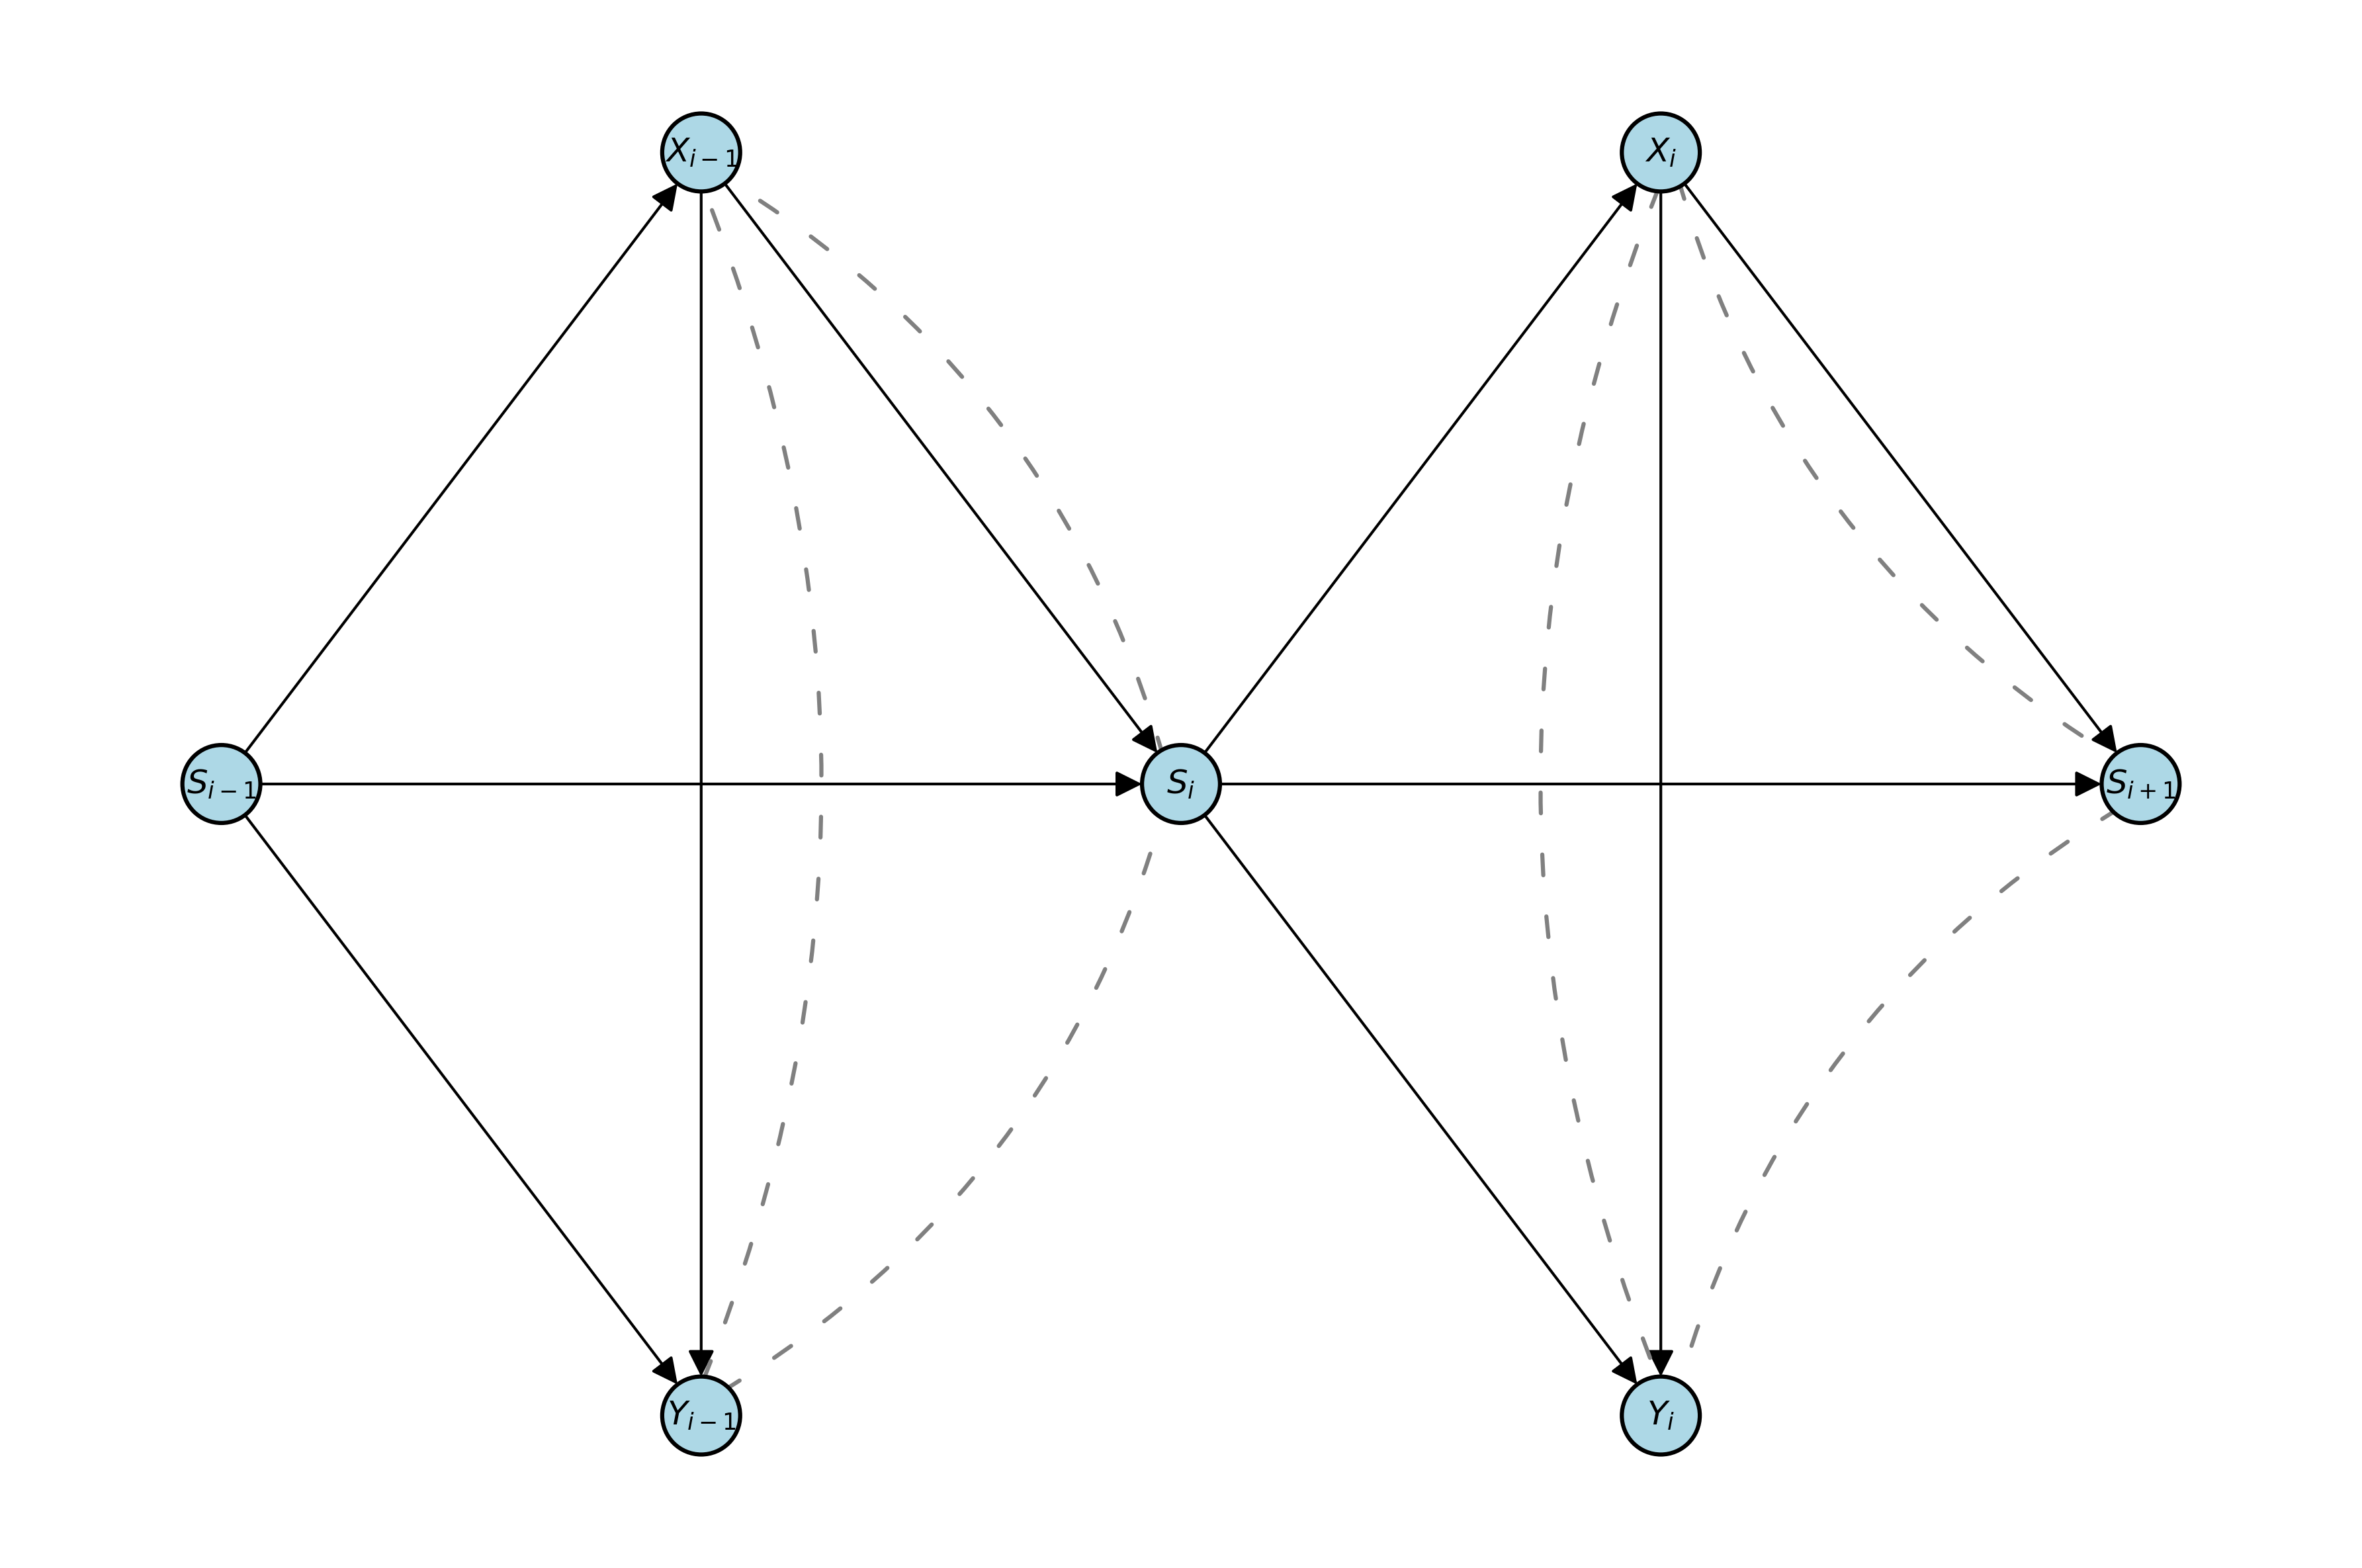

In [5]:

cdag = causal_graph.CausalGraph({'S_i','X_i','S_{i-1}','X_{i-1}','Y_i','Y_{i-1}','S_{i+1}'},
                           [('S_{i-1}','X_{i-1}'),('S_{i-1}','S_i'),('X_{i-1}','S_i'),('S_i','X_i'),('S_i','Y_i'),('X_i','Y_i'),
                            ('X_{i-1}','Y_{i-1}'),('S_{i-1}','Y_{i-1}'), ('S_i','S_{i+1}'), ('X_i','S_{i+1}')],
                           [('S_i','X_{i-1}','U_{i-1,1}'),('X_i','Y_i','U_{i,1}'),
                            ('X_{i-1}','Y_{i-1}','U_{i-1,1}'), ('S_i','Y_{i-1}','U_{i,1}'), ('S_{i+1}','X_i','U_{i,1}'), 
                            ('S_{i+1}','Y_i','U_{i+1,1}')])
cdag.nx_viz(pos = pos, labels = labels)

In [34]:
import multiprocess as mp
from multiprocess import Process

def worker(policy=None):
    env = MDPExamplePCH(max_step=1000)
    s, _ = env.reset()
    done = False
    reward = 0
    while not done:
        if policy is None:
            x, s, y, _, done, _ = env.see()
        else:
            s, y, _, done, _ = env.do(policy(s))
        reward = reward * GAMMA + y
    results.append(reward)


manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': None}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Behavioral policy avg discounted return is {sum(results)/len(results)}')

Behavioral policy avg discounted return is 1.0067280566338819


### Evaluating Optimal Atomic Policy

However, we can have a better interventional policy that takes actions by $X_i \leftarrow S_i$, at each time step, we can achieve an expected reward of $$\mathbb{E}[Y_i|s_i, x_i] = 0.82$$

Thus, if we evaluate this interventional policy for infinitely long, we would have a discounted cumulative reutrn of,
$$\mathbb{E}[\sum_{i=1}^\infty \gamma^{i-1}Y_i] = \frac{0.82}{1-\gamma}$$

In the following simulation, we use $\gamma = .9$ so we will see a cumulative return close to $\frac{0.82}{1- .9} = 8.2$.

In [35]:
# The interventional policy
policy = lambda s: s
manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': policy}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Atomic interventional policy avg discounted return is {sum(results)/len(results)}')

Atomic interventional policy avg discounted return is 8.18904422777848
